# Import Dependencies and Data

In [2]:
# import operating system 
import os

In [3]:
# import plotting dependencies
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt 
%matplotlib inline 

In [4]:
# import SciKitLearn, Keras, tensorflow, and image "rendering"
# cv2 is a Python library of bindings designed to solve computer vision problems
import cv2
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from concurrent import futures 
import threading 

# Load Data into DataFrames

In [5]:
# Validation data files 
base_dir = os.path.join('cell_images/valid')

# Find validation data, and sort into parasitized and uninfected using glob, a python module which will iterate 
# through all images (as png files) and create a list of files in a directory. Glob follows UNIX path expansion rules.
valid_para_dir = os.path.join(base_dir,'Parasitized')
valid_para_files = glob.glob(valid_para_dir+'/*.png')

valid_healthy_dir = os.path.join(base_dir,'Uninfected')
valid_healthy_files = glob.glob(valid_healthy_dir+'/*.png')

In [6]:
# Length of files from validation set 
len(valid_para_files), len(valid_healthy_files)

(2756, 2756)

In [7]:
# Create validation data dataframe
valid_df = pd.DataFrame({'filename': valid_para_files + valid_healthy_files, 
           'label': ['Parasitized'] * len(valid_healthy_files) +
                    ['Uninfected'] * len(valid_healthy_files)}).sample(frac=1, random_state=42).reset_index(drop=True)
valid_df.head()

,filename,label
0,cell_images/valid/Uninfected/C205ThinF_IMG_201...,Uninfected
1,cell_images/valid/Uninfected/C75P36_ThinF_IMG_...,Uninfected
2,cell_images/valid/Parasitized/ParasitizedC39P4...,Parasitized
3,cell_images/valid/Uninfected/C72P33_ThinF_IMG_...,Uninfected
4,cell_images/valid/Parasitized/ParasitizedC180P...,Parasitized


In [8]:
# first sanity check 
valid_df.info()
valid_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5512 entries, 0 to 5511
Data columns (total 2 columns):
filename    5512 non-null object
label       5512 non-null object
dtypes: object(2)
memory usage: 86.2+ KB


(5512, 2)

In [9]:
# Training data files 
base_dir = os.path.join('cell_images/train')
train_para_dir = os.path.join(base_dir,'Parasitized')
train_para_files = glob.glob(train_para_dir+'/*.png')
train_healthy_dir = os.path.join(base_dir,'Uninfected')
train_healthy_files = glob.glob(train_healthy_dir+'/*.png')

In [10]:
# Length of files from validation set 
len(train_para_files), len(train_healthy_files)

(11023, 11023)

In [11]:
# Create training data dataframe 
train_df = pd.DataFrame({'filename': train_para_files + train_healthy_files,
           'label': ['Parasitized'] * len(train_para_files) + 
                    ['Uninfected'] * len(train_healthy_files)}).sample(frac=1, random_state=42).reset_index(drop=True)

train_df.head()

,filename,label
0,cell_images/train/Parasitized/C128P89ThinF_IMG...,Parasitized
1,cell_images/train/Uninfected/C53P14thinF_IMG_2...,Uninfected
2,cell_images/train/Parasitized/C99P60ThinF_IMG_...,Parasitized
3,cell_images/train/Parasitized/C186P147NThinF_I...,Parasitized
4,cell_images/train/Parasitized/C59P20thinF_IMG_...,Parasitized


In [12]:
# second sanity check
train_df.info()
train_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22046 entries, 0 to 22045
Data columns (total 2 columns):
filename    22046 non-null object
label       22046 non-null object
dtypes: object(2)
memory usage: 344.5+ KB


(22046, 2)

In [13]:
# combine the two different dataframes from the training and validation data 
dataframes = [valid_df, train_df]
df = pd.concat(dataframes)

df.head()

,filename,label
0,cell_images/valid/Uninfected/C205ThinF_IMG_201...,Uninfected
1,cell_images/valid/Uninfected/C75P36_ThinF_IMG_...,Uninfected
2,cell_images/valid/Parasitized/ParasitizedC39P4...,Parasitized
3,cell_images/valid/Uninfected/C72P33_ThinF_IMG_...,Uninfected
4,cell_images/valid/Parasitized/ParasitizedC180P...,Parasitized


In [14]:
# third  sanity check because things often get weird up in here. 
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27558 entries, 0 to 22045
Data columns (total 2 columns):
filename    27558 non-null object
label       27558 non-null object
dtypes: object(2)
memory usage: 645.9+ KB


(27558, 2)

# Image Pre-Processing

In [15]:
# set random seed for reproducibility across different users 
np.random.seed(42)

In [16]:
# train test split and get shape of files 
train_files, test_files, train_labels, test_labels = train_test_split(df['filename'].values,
                                                                      df['label'].values,
                                                                      test_size=0.3, random_state=42)

train_files, valid_files, train_labels, valid_labels = train_test_split(train_files,
                                                                    train_labels,
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, valid_files.shape, test_files.shape)
print('Training:', Counter(train_labels),'\nValidation:', Counter(valid_labels), '\nTesting:', Counter(test_labels))

(17361,) (1929,) (8268,)
Training: Counter({'Parasitized': 8682, 'Uninfected': 8679}) 
Validation: Counter({'Uninfected': 977, 'Parasitized': 952}) 
Testing: Counter({'Parasitized': 4145, 'Uninfected': 4123})


In [17]:
# this is to get the image shapes since they all might not be the same
def get_img_shape_parallel(index, image, total_images):
    if index % 5000 == 0 or index == (total_images - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name, index))
        
    return cv2.imread(image).shape
  
execute = futures.ThreadPoolExecutor(max_workers=None)
data_input = [(index, image, len(train_files)) for index, image in enumerate(train_files)]
print('Starting Image shape Computations...')

train_image_dimensions_map = execute.map(get_img_shape_parallel, 
                            [record[0] for record in data_input],
                            [record[1] for record in data_input],
                            [record[2] for record in data_input])
train_image_dimensions = list(train_image_dimensions_map)

print('Min Dimensions:', np.min(train_image_dimensions, axis=0)) 
print('Avg Dimensions:', np.mean(train_image_dimensions, axis=0))
print('Median Dimensions:', np.median(train_image_dimensions, axis=0))
print('Max Dimensions:', np.max(train_image_dimensions, axis=0))

Starting Image shape Computations...
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_20: working on img num: 5000
ThreadPoolExecutor-0_24: working on img num: 10000
ThreadPoolExecutor-0_0: working on img num: 15000
ThreadPoolExecutor-0_4: working on img num: 17360
Min Dimensions: [50 50  3]
Avg Dimensions: [50. 50.  3.]
Median Dimensions: [50. 50.  3.]
Max Dimensions: [50 50  3]


In [18]:
# load images in the defined size so that they are consistent 
img_dims = (50, 50)

def get_img_data_parallel(index, image, total_images):
    if index % 5000 == 0 or index == (total_images - 1):
        print('{}: working on image number: {}'.format(threading.current_thread().name, index))
    image = cv2.imread(image)
    image = cv2.resize(image, dsize= img_dims, 
                     interpolation=cv2.INTER_CUBIC)
    image = np.array(image, dtype=np.float32)
    return image

execute = futures.ThreadPoolExecutor(max_workers=None)

train_data_input = [(index, image, len(train_files)) for index, image in enumerate(train_files)]
valid_data_input = [(index, image, len(valid_files)) for index, image in enumerate(valid_files)]
test_data_input = [(index, image, len(test_files)) for index, image in enumerate(test_files)]

print('Loading Train Images...')
train_data_map = execute.map(get_img_data_parallel, 
                        [record[0] for record in train_data_input],
                        [record[1] for record in train_data_input],
                        [record[2] for record in train_data_input])
train_data = np.array(list(train_data_map))
print(f"Training Data Shape: {train_data.shape}")
print("-"*60)
print('Loading Validation Images...')
valid_data_map = execute.map(get_img_data_parallel, 
                        [record[0] for record in valid_data_input],
                        [record[1] for record in valid_data_input],
                        [record[2] for record in valid_data_input])
valid_data = np.array(list(valid_data_map))
print(f"Validation Data Shape: {valid_data.shape}")
print("-"*60)
print('Loading Test Images...')
test_data_map = execute.map(get_img_data_parallel, 
                        [record[0] for record in test_data_input],
                        [record[1] for record in test_data_input],
                        [record[2] for record in test_data_input])
test_data = np.array(list(test_data_map))
print(f"Testing Data Shape: {test_data.shape}")

Loading Train Images...
ThreadPoolExecutor-1_0: working on image number: 0
ThreadPoolExecutor-1_0: working on image number: 5000
ThreadPoolExecutor-1_8: working on image number: 10000
ThreadPoolExecutor-1_12: working on image number: 15000
ThreadPoolExecutor-1_36: working on image number: 17360
Training Data Shape: (17361, 50, 50, 3)
------------------------------------------------------------
Loading Validation Images...
ThreadPoolExecutor-1_20: working on image number: 0
ThreadPoolExecutor-1_11: working on image number: 1928
Validation Data Shape: (1929, 50, 50, 3)
------------------------------------------------------------
Loading Test Images...
ThreadPoolExecutor-1_23: working on image number: 0
ThreadPoolExecutor-1_9: working on image number: 5000
ThreadPoolExecutor-1_3: working on image number: 8267
Testing Data Shape: (8268, 50, 50, 3)


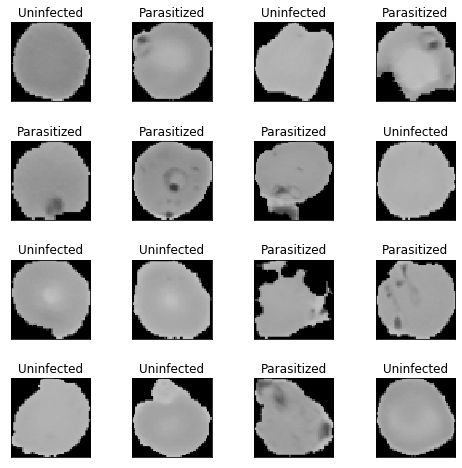

In [19]:
# use matplotlib to print pictures 
plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    
    plt.subplot(4 , 4 , n)
    
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    
    plt.imshow(train_data[r[0]]/255.)
    
    plt.title('{}'.format(train_labels[r[0]]))
    
    plt.xticks([]) , plt.yticks([])

In [20]:
# labels for images
scaled_train_images = train_data / 255
scaled_valid_images = valid_data / 255

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_labels)
enc_train_labels = le.transform(train_labels)
enc_valid_labels= le.transform(valid_labels)

print(train_labels[:16], enc_train_labels[:16])

['Uninfected' 'Uninfected' 'Parasitized' 'Uninfected' 'Parasitized'
 'Uninfected' 'Uninfected' 'Uninfected' 'Parasitized' 'Parasitized'
 'Parasitized' 'Parasitized' 'Uninfected' 'Parasitized' 'Uninfected'
 'Uninfected'] [1 1 0 1 0 1 1 1 0 0 0 0 1 0 1 1]


In [21]:
tf.random.set_seed(42)
tf.__version__

'2.1.0'

# Now for the Neural Network

In [22]:
# definte image input shape for consistency
input_shape = (50, 50, 3)
input = tf.keras.layers.Input(shape= input_shape)

In [23]:
# build model architecture 
conv_1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(input)
pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_1)

conv_2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(pool_1)
pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)

conv_3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(pool_2)
pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_3)

flat = tf.keras.layers.Flatten()(pool_3)

In [24]:
# build-in dropouts since this dataset is relatively small, over-fitting is likely. The drop out rate of 0.5 is chosen arbitrarily. 
hidden_1 = tf.keras.layers.Dense(512, activation='relu')(flat)
dropout_1 = tf.keras.layers.Dropout(rate=0.5)(hidden_1)

hidden_2 = tf.keras.layers.Dense(512, activation='relu')(dropout_1)
dropout_2 = tf.keras.layers.Dropout(rate=0.5)(hidden_2)

output = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_2)

In [25]:
my_model = tf.keras.Model(inputs = input, outputs = output)

In [26]:
my_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
my_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 50, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0     

In [27]:
#import datetime
logdir = os.path.join('../tensorboard_logs', 
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [28]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.000001)

callbacks = [reduce_lr, tensorboard_callback]

In [29]:
Batch_Size = 64
number_classes = 2 
Epics = 25
Validation = (scaled_valid_images, enc_valid_labels)

In [30]:
history = my_model.fit(x=scaled_train_images, 
                    y=enc_train_labels, 
                    batch_size=Batch_Size, 
                    epochs=Epics, 
                    validation_data=Validation,
                    callbacks=callbacks, 
                    verbose=1)

Train on 17361 samples, validate on 1929 samples
Epoch 1/25
17361/17361 [==============================] - 26s 1ms/sample - loss: 0.5050 - accuracy: 0.7211 - val_loss: 0.1984 - val_accuracy: 0.9404
Epoch 2/25
17361/17361 [==============================] - 26s 1ms/sample - loss: 0.1836 - accuracy: 0.9347 - val_loss: 0.1523 - val_accuracy: 0.9518
Epoch 3/25
17361/17361 [==============================] - 26s 2ms/sample - loss: 0.1557 - accuracy: 0.9445 - val_loss: 0.1490 - val_accuracy: 0.9518
Epoch 4/25
17361/17361 [==============================] - 26s 2ms/sample - loss: 0.1454 - accuracy: 0.9472 - val_loss: 0.1494 - val_accuracy: 0.9492
Epoch 5/25
17361/17361 [==============================] - 26s 2ms/sample - loss: 0.1329 - accuracy: 0.9526 - val_loss: 0.1375 - val_accuracy: 0.9539
Epoch 6/25
17361/17361 [==============================] - 27s 2ms/sample - loss: 0.1251 - accuracy: 0.9546 - val_loss: 0.1401 - val_accuracy: 0.9549
Epoch 7/25
17361/17361 [==============================] -

In [31]:
max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))

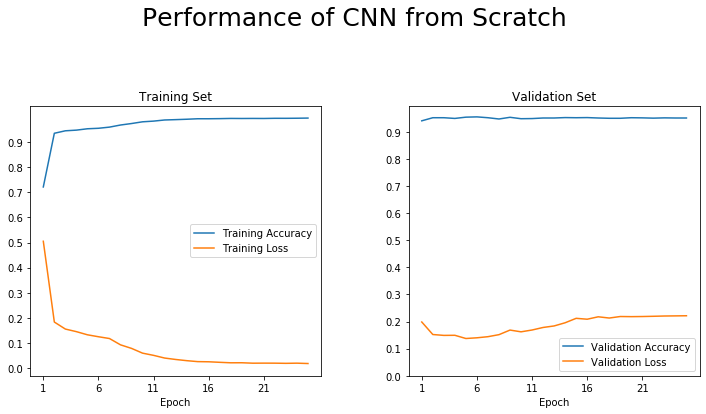

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
t = f.suptitle('Performance of CNN from Scratch', fontsize=25)
f.subplots_adjust(top=0.75, wspace=0.3)

# figure 1
ax1.plot(epoch_list, history.history['accuracy'], label='Training Accuracy')
ax1.plot(epoch_list, history.history['loss'], label='Training Loss')

ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_yticks(np.arange(0, 1, step=0.1))
ax1.set_xlabel('Epoch')
ax1.set_title('Training Set')

l1 = ax1.legend(loc="best")

# figure 2
ax2.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')

ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_yticks(np.arange(0, 1, step=0.1))
ax2.set_xlabel('Epoch')
ax2.set_title('Validation Set')

l2 = ax2.legend(loc="best")

In [33]:
type(my_model)

tensorflow.python.keras.engine.training.Model

In [45]:
my_model.save("my_cnn.h5")

In [49]:
# added these imports found on this page https://github.com/tensorflow/tensorflow/issues/33474 to load model and save
# this is the best way to load a model 
from tensorflow.keras.layers import Input, Embedding, Activation, Flatten, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.models import Model

In [50]:
test = tf.keras.models.load_model('my_cnn.h5')

In [58]:
test.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 50, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0     

# Testing Our Data Against VGG19

In [59]:
# Dependencies
import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import (
    VGG19, 
    preprocess_input, 
    decode_predictions
)

In [60]:
# Load the VGG19 model
# https://keras.io/applications/#VGG19
model = VGG19(include_top=True, weights='imagenet')

In [61]:
# Define default image size for VGG19
img_size = (224, 224)

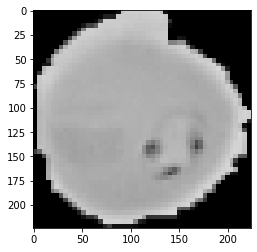

In [62]:
# Load the image and resize to default image size
image_path = os.path.join("cell_images/train/Parasitized/C33P1thinF_IMG_20150619_114756a_cell_179.png")
img = image.load_img(image_path, target_size=img_size)
plt.imshow(img)

In [63]:
# Preprocess image for model prediction
# This step handles scaling and normalization for VGG19
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

Predicted: [[('n04346328', 'stupa', 0.27191412), ('n03028079', 'church', 0.066419385), ('n02825657', 'bell_cote', 0.056841865)]]


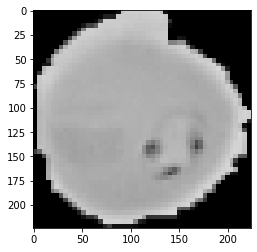

In [64]:
# Make predictions
predictions = model.predict(x)
print('Predicted:', decode_predictions(predictions, top=3))
plt.imshow(img)

In [65]:
# Refactor above steps into reusable function
def predict(image_path):
    img = image.load_img(image_path, target_size=image_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    predictions = model.predict(x)
    plt.imshow(img)
    
print('Predicted Image:', decode_predictions(predictions, top=3))

Predicted Image: [[('n04346328', 'stupa', 0.27191412), ('n03028079', 'church', 0.066419385), ('n02825657', 'bell_cote', 0.056841865)]]


# And Another One *DJ Khalid Voice* (Just kidding it's still VGG19)

In [61]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                zoom_range=0.05, 
                                                                rotation_range=25,
                                                                width_shift_range=0.05, 
                                                                height_shift_range=0.05, 
                                                                shear_range=0.05, horizontal_flip=True, 
                                                                fill_mode='nearest')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Labels: ['Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized']


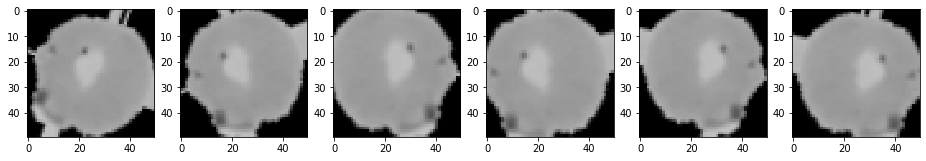

In [62]:
img_id = 0
sample_generator = train_datagen.flow(train_data[img_id:img_id+1], train_labels[img_id:img_id+1],
                                      batch_size=1)
sample = [next(sample_generator) for i in range(0,6)]
fig, ax = plt.subplots(1,6, figsize=(16, 8))
print('Labels:', [item[1][0] for item in sample])
l = [ax[i].imshow(sample[i][0][0]) for i in range(0,6)]

In [63]:
Batch_Size = 64
number_classes = 2 
Epics = 25
Validation = (scaled_valid_images, enc_valid_labels)
input_shape = (50, 50, 3)
input = tf.keras.layers.Input(shape= input_shape)

In [64]:
train_generator = train_datagen.flow(train_data, enc_train_labels, batch_size=Batch_Size, shuffle=True)
val_generator = val_datagen.flow(valid_data, enc_valid_labels, batch_size=Batch_Size, shuffle=False)

In [65]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=input_shape)
# Freeze the layers
vgg.trainable = True

set_trainable = False
for layer in vgg.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.5)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.5)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])

print("Total Layers:", len(model.layers))
print("Total trainable layers:", sum([1 for l in model.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 16


In [71]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.000001)

callbacks = [reduce_lr, tensorboard_callback]

train_steps_per_epoch = train_generator.n // train_generator.batch_size

val_steps_per_epoch = val_generator.n // val_generator.batch_size

In [72]:
history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, 
                              epochs=Epics,
                              validation_data=val_generator, 
                              validation_steps=val_steps_per_epoch, 
                              verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 271 steps, validate for 30 steps
Epoch 1/25
271/271 [==============================] - 376s 1s/step - loss: 0.3882 - accuracy: 0.8252 - val_loss: 0.2006 - val_accuracy: 0.9167
Epoch 2/25
271/271 [==============================] - 385s 1s/step - loss: 0.2556 - accuracy: 0.8984 - val_loss: 0.1782 - val_accuracy: 0.9302
Epoch 3/25
271/271 [==============================] - 381s 1s/step - loss: 0.2126 - accuracy: 0.9186 - val_loss: 0.1608 - val_accuracy: 0.9344
Epoch 4/25
271/271 [==============================] - 367s 1s/step - loss: 0.1933 - accuracy: 0.9255 - val_loss: 0.1648 - val_accuracy: 0.9370
Epoch 5/25
271/271 [==============================] - 366s 1s/step - loss: 0.1812 - accuracy: 0.9274 - val_loss: 0.1736 - val_accuracy: 0.9427
Epoch 6/25
271/271 [==============================] - 409s 2s/step - loss: 0.1717 - accuracy: 0.9339 - val_loss: 0.1

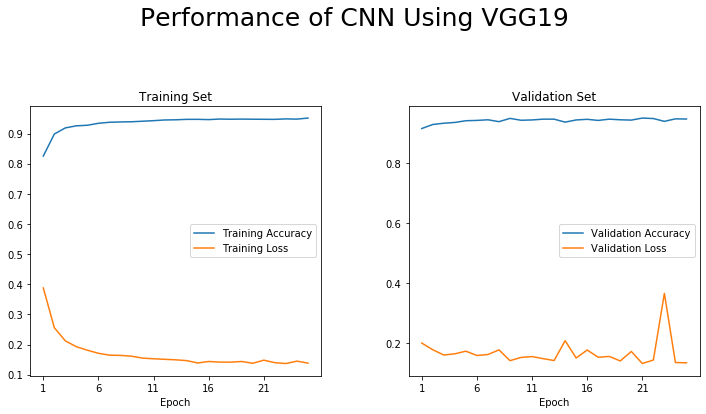

In [115]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
t = f.suptitle('Performance of CNN Using VGG19', fontsize=25)
f.subplots_adjust(top=0.75, wspace=0.3)

# figure 1
ax1.plot(epoch_list, history.history['accuracy'], label='Training Accuracy')
ax1.plot(epoch_list, history.history['loss'], label='Training Loss')

ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_xlabel('Epoch')
ax1.set_title('Training Set')

l1 = ax1.legend(loc="best")

# figure 2
ax2.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')

ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_xlabel('Epoch')
ax2.set_title('Validation Set')

l2 = ax2.legend(loc="best")

In [139]:
model.save("my_vgg.h5", include_optimizer=False)

# Comparing Models 

In [56]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

In [53]:
# load saved models
#basic_cnn = load_model('my_cnn.h5')
#img_aug_cnn = load_model('my_vgg.h5')

In [57]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])

NameError: name 'model' is not defined

In [143]:
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape

AttributeError: 'list' object has no attribute 'shape'

In [144]:
# Make Predictions on Test Data
basic_cnn_preds = basic_cnn.predict(test_imgs_scaled, batch_size=512)
vgg_ft_preds = vgg_ft.predict(test_imgs_scaled, batch_size=512)

basic_cnn_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in basic_cnn_preds.ravel()])
vgg_frz_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in vgg_frz_preds.ravel()])


NameError: name 'vgg_ft' is not defined